In [98]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
from glob import glob

In [99]:
%load_ext autoreload
%autoreload 1
%aimport data_utils
%aimport contrastive_data
%aimport sc_eVIP.score
%aimport main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *


In [101]:
from sc_eVIP import score as sceVIP_score

# Data

In [102]:
gene = 'KRAS'
data_path = f'/home/lguirardel/data/perturb_comp/data/{gene}/'


In [103]:
group_wt_like = True
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=False)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		97 variant classes


In [104]:
metadata = pd.read_csv(paths[4], index_col=0) # contains T2 scores and control status
metadata['Control status'].value_counts()

Control status
unknown       75
synonymous    16
ExAC          10
Name: count, dtype: int64

In [105]:
control_status = metadata['Control status'].dropna().isin(['synonymous'])
control_status.value_counts()


Control status
False    85
True     16
Name: count, dtype: int64

Ursu et al subsampled to 1k cell/variant, which is conserved here

In [106]:
counts.variant.value_counts()

variant
A130V    1000
G75A     1000
Q25H     1000
Q22H     1000
M170L    1000
         ... 
Q61K      599
K5E       529
G12S      498
G12D      496
G12V      406
Name: count, Length: 97, dtype: int64

In [164]:
metadata.loc['G13R']

Gene                                                                                      KRAS
Position: base(s)                                                                           37
From ORF base(s)                                                                             G
To ORF base(s)                                                                               C
Position: amino acid(s)                                                                     13
From amino acid(s)                                                                           G
To amino acid(s)                                                                             R
From ORF codon(s)                                                                          GGC
To ORF codon(s)                                                                            CGC
Mutation type                                                                           Single
Control status                                    

# PCA

Reproduce results from Ursu et al. They used all data, and so will we here

In [108]:
pca = PCA(20)
df = counts.drop(columns=['variant','Variant functional class',])
X_red = pca.fit_transform(df)
X_red = pd.DataFrame(X_red, index = df.index)

In [109]:
result = sceVIP_score.compare_groups_with_reference(

    X_red,
    pd.DataFrame(counts.variant.rename('label')),
    groups=counts.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 15/15 controls
1 %

100 %

In [110]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
Q61H,7328.523763,7061.516185,7595.531342,1.952707,1.943781,1.961632,0.000010,0.000010
T74A,439.985414,400.598845,479.371984,0.615762,0.560566,0.670958,0.000010,0.000010
K5E,651.788206,614.813554,688.762859,0.988562,0.946021,1.031103,0.000010,0.000010
T20M,377.551145,350.818742,404.283548,0.486656,0.444684,0.528628,0.000010,0.000010
A146T,7617.462903,7353.730441,7881.195365,1.893141,1.877225,1.909058,0.000010,0.000010
...,...,...,...,...,...,...,...,...
I163S,66.892767,60.170914,73.614621,0.076864,0.065564,0.088165,0.031470,0.535991
K169K,36.446233,29.755624,43.136843,0.064381,0.046034,0.082728,0.576594,0.605000
A146P,6172.291228,5934.659069,6409.923387,1.911222,1.897028,1.925417,0.000010,0.000010
G12F,3338.676082,3212.136598,3465.215567,1.783965,1.754651,1.813279,0.000010,0.000010


        Recomputed        Paper
M111L    26.345879    26.248723
S136N    27.025864    26.672454
K179R    30.398146    29.958400
V8V      30.213525    30.347129
T144T      30.5922    30.545139
...            ...          ...
Q61L   9552.745484  9515.380160
G13R   9600.902417  9582.732490
G13D           NaN          NaN
G12L           NaN          NaN
Q70Q           NaN          NaN

[102 rows x 2 columns]


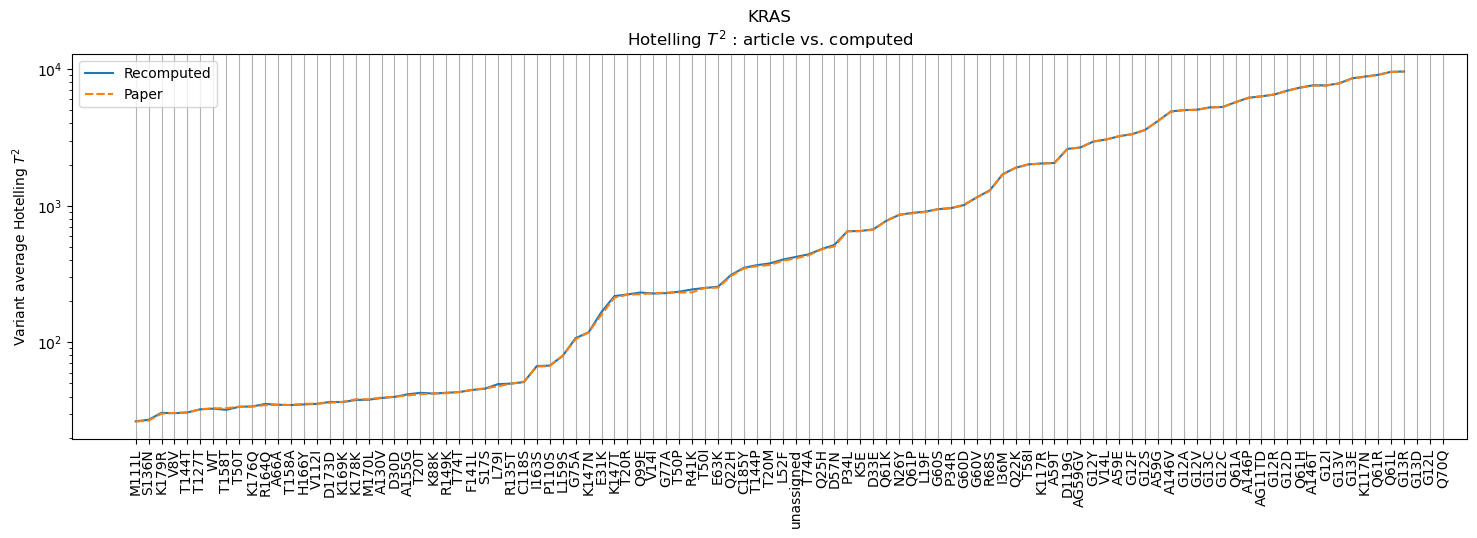

In [111]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename('Recomputed'), metadata['HotellingT2'].rename('Paper')), axis=1) #.dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
print(df)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ : article vs. computed')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x');


In [112]:
df[df.isna().any(axis=1)]

,Recomputed,Paper
H166Y,NaN,35.441848
unassigned,NaN,411.459204
G13D,NaN,NaN
G12L,NaN,NaN
Q70Q,NaN,NaN


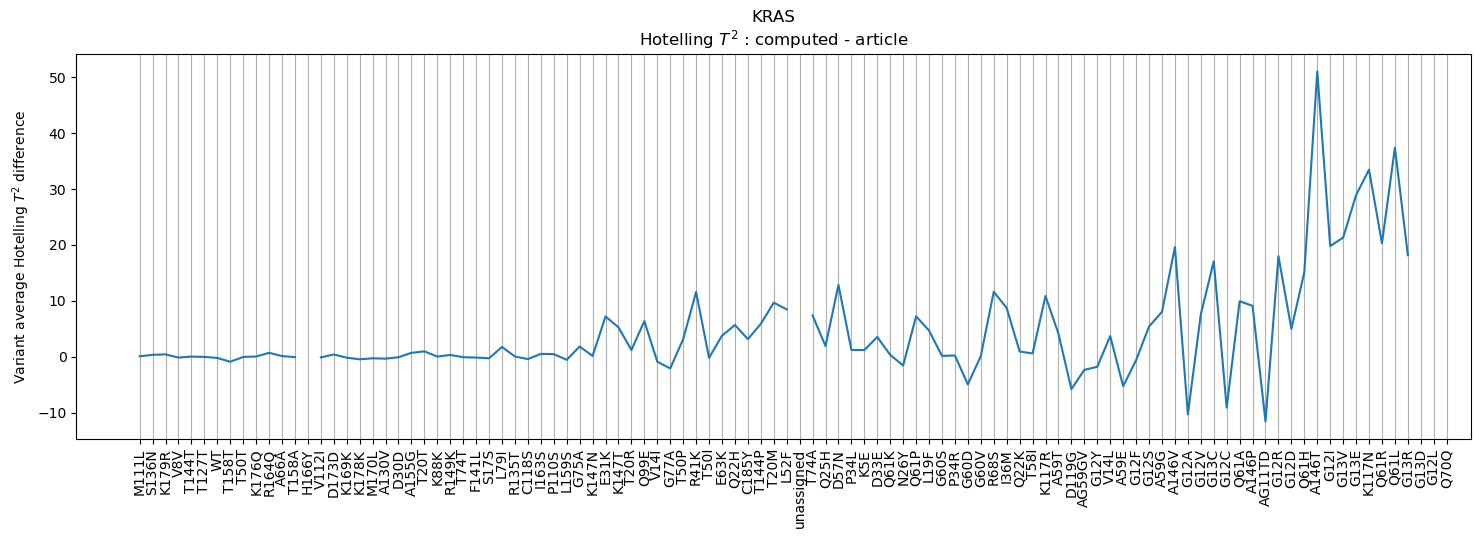

In [113]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)
plt.title(f'{gene}\nHotelling $T^2$ : computed - article')
plt.ylabel('Variant average Hotelling $T^2$ difference');

Nb : the difference observed here has some randomness. I suspect this might be due to the package used to compute Hotellings $T^2$. ~~I don't think it has a 0 expectancy, which means there's still likely to be something wrong.~~ It actually might have 0 expectancy, which means I might be worried for nothing

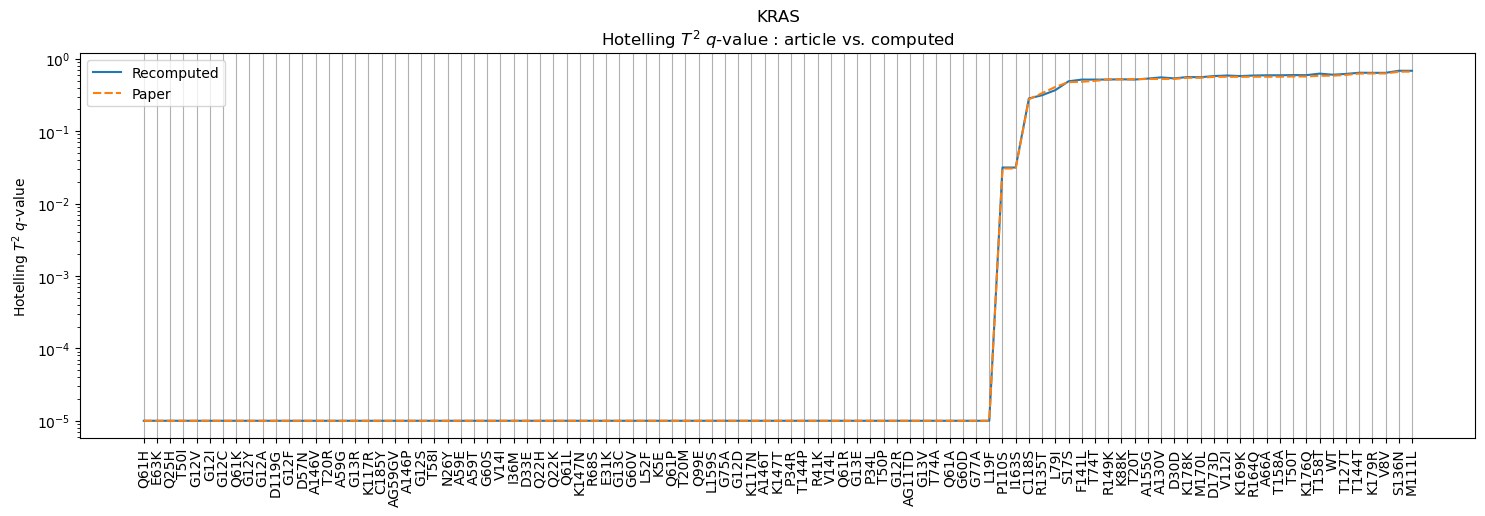

In [114]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename('Recomputed'), metadata['HotellingT2.q'].rename('Paper')), axis=1).dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
# print(df)
plt.grid(axis='x')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ $q$-value : article vs. computed')
plt.ylabel('Hotelling $T^2$ $q$-value');

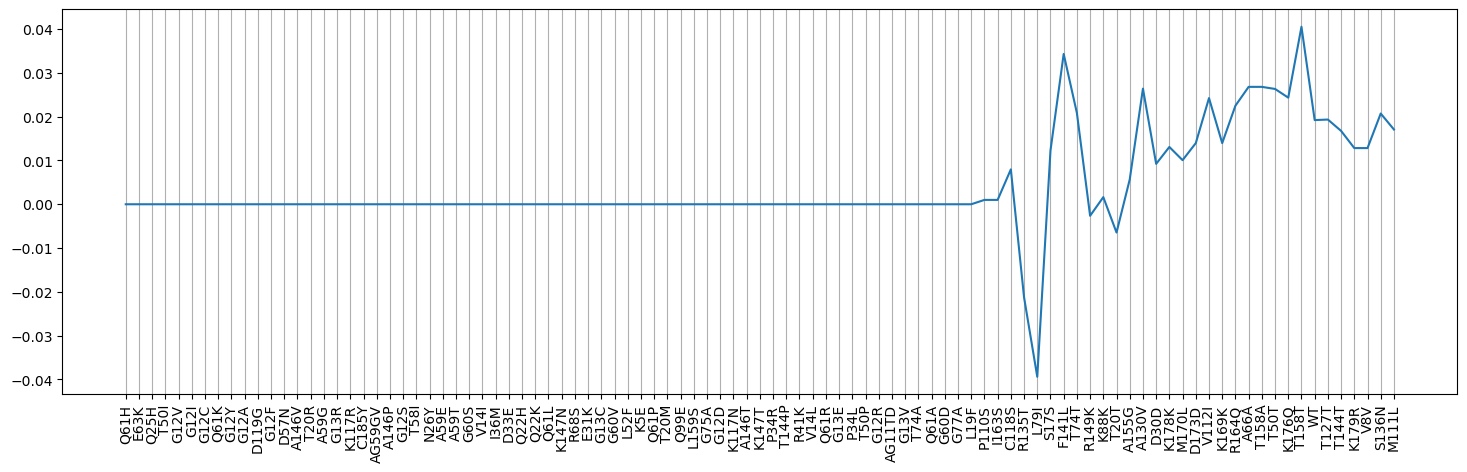

In [115]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)

# Model

In [193]:
run_name = 'KRAS_007_cls'
dir_name = join('models',run_name)
! cat models/{run_name}/config.ini

load-split = KRAS_006
weight-decay = 0.05
batch-size = 256
task = classifier
loss = standard
margin = 1
alpha = 0
dropout = 0.2
positive-fraction = 0.5
lr = 0.001
n-epochs = 400
shape = [100, 100]
embed-dim = 20
n-workers = 0
knn = 3


In [194]:
save_dir = f'plots/var_scores/{run_name}'
make_dir_if_needed(save_dir)

## Test run : not an actual good scoring protocol

### Embeddings

In [195]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, reorder_categories=False)
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

/home/lguirardel/work/sc_contrast/main.py:91: UserWarning: Not reordering categories will lead to wrong classifier prediction
  warn('Not reordering categories will lead to wrong classifier prediction')


77 variants in train
20 variants in unseen


In [196]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

Classifier(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1145, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=100, out_features=20, bias=True)
    )
  )
  (output_layer): Linear(in_features=20, out_features=63, bias=True)
)

In [197]:
emb_dict = {}
for k, df in df_dict.items():
    X = torch.tensor(df.drop(columns=['variant','Variant functional class', ]).to_numpy(), dtype=torch.float32)
    embeds = []
    for i,x in enumerate(X):
        with torch.no_grad():
            embeds.append(model.network.forward(x))
    emb_dict[k] = torch.stack(embeds)

In [198]:
emb_dim = emb_dict['train'].size(1)
print("Embedding dimension :", emb_dim)

Embedding dimension : 20


### Scoring

In [199]:
subset = 'seen' #unseen does not mean much as we have to few controls
df = df_dict[subset]
embeds = emb_dict[subset]

# embeds = (embeds - embeds.mean(dim=0, keepdim=True))/embeds.std(dim=0, keepdim=True)

In [200]:
result = sceVIP_score.compare_groups_with_reference(
    pd.DataFrame(embeds, index=df.index),
    pd.DataFrame(df.variant.rename('label')),
    groups=df.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 15/15 controls
2 %

100 %

In [201]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
Q61H,2541.997935,2380.383273,2703.612596,1.423321,1.391817,1.454825,0.000010,0.000010
K5E,256.54381,237.618195,275.469426,1.556702,1.523665,1.589739,0.000010,0.000010
T20M,207.729963,193.028415,222.431511,0.964795,0.931743,0.997848,0.000010,0.000010
G12R,2552.989452,2364.314561,2741.664344,1.475183,1.444347,1.506018,0.000010,0.000010
Q61P,269.941767,251.252592,288.630942,1.423881,1.388257,1.459505,0.000010,0.000010
...,...,...,...,...,...,...,...,...
T58I,633.953873,593.471861,674.435884,1.767548,1.7464,1.788696,0.000010,0.000010
G12S,1181.715858,1102.325629,1261.106087,1.602585,1.5764,1.62877,0.000010,0.000010
I163S,25.77103,22.294078,29.247983,0.020389,0.016299,0.024478,0.498652,0.375215
K169K,18.436028,16.485779,20.386276,0.010186,0.006757,0.013616,0.688372,0.607073


### Figures

In [202]:
def color_tick(ticklabel):
    variant = ticklabel.get_text()
    if control_status[variant ] :
        ticklabel.set_color('red')
    else:
        if metadata.loc[variant, 'Variant functional class']=='WT-like':
            ticklabel.set_color('C1')
        if metadata.loc[variant, 'Variant functional class']=='Impactful IV (gain-of-function)':
            ticklabel.set_color('purple')
        # if metadata.loc[variant, 'Variant functional class']=='WT-like':
        #     ticklabel.set_color('orange')   

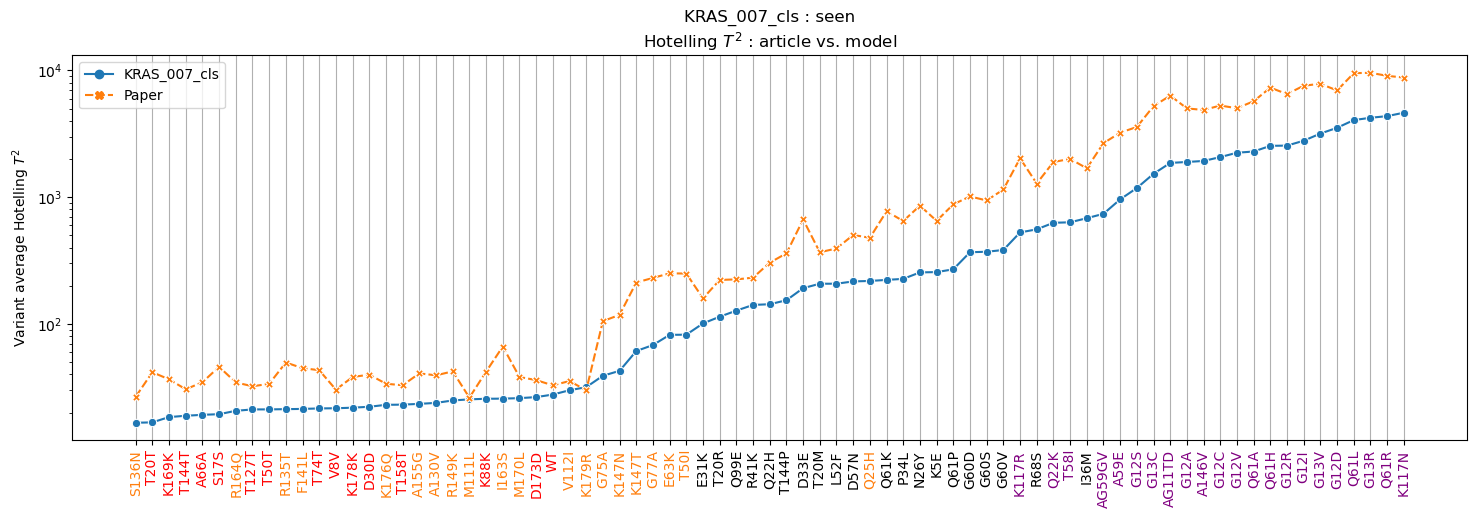

In [203]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename(run_name), metadata['HotellingT2'].rename('Paper')), axis=1).dropna()
df = df.sort_values(run_name)
sns.lineplot(data=df, markers=True)
plt.yscale('log')
plt.xticks(rotation=90)

for ticklabel in plt.gca().get_xticklabels():
    color_tick(ticklabel)

plt.title(f'{run_name} : {subset}\nHotelling $T^2$ : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x')
plt.savefig(save_dir+f'/{subset}_T2.pdf');

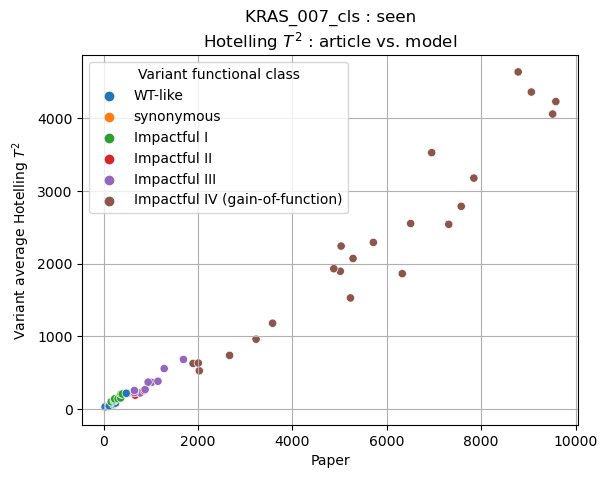

In [204]:
hue = metadata.loc[df.index, 'Variant functional class'].copy()
hue[metadata['Control status'] == 'synonymous'] = 'synonymous'
sns.scatterplot(df, x='Paper', y=run_name, hue=hue)
plt.title(f'{run_name} : {subset}\nHotelling $T^2$ : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid()
plt.savefig(save_dir+f'/{subset}_T2_scatter.pdf');

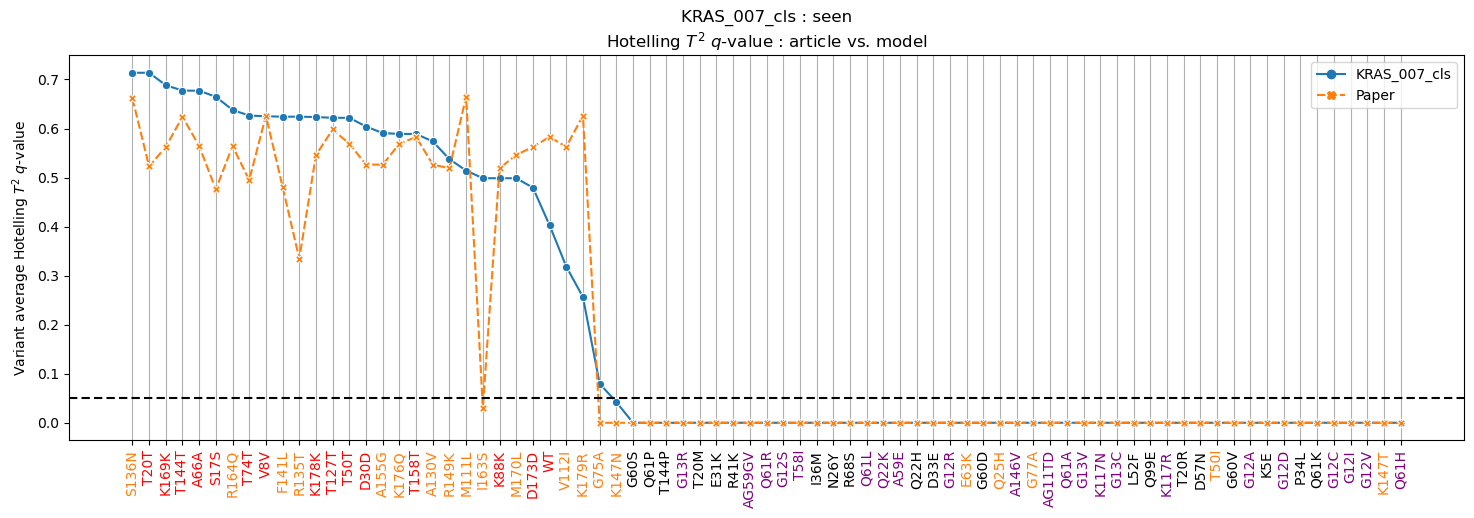

In [205]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename(run_name), metadata['HotellingT2.q'].rename('Paper')), axis=1).dropna()
df = df.sort_values(run_name, ascending=False)
sns.lineplot(data=df, markers=True)
# plt.yscale('log')
plt.xticks(rotation=90)

for ticklabel in plt.gca().get_xticklabels():
   color_tick(ticklabel)

plt.title(f'{run_name} : {subset}\nHotelling $T^2$ $q$-value : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$ $q$-value')
plt.grid(axis='x')
plt.axhline(0.05, dashes=[4,2], color='k')
plt.savefig(save_dir+f'/{subset}_T2_q.pdf');